In [ ]:
pip install pysindy matplotlib numpy scipy

In [ ]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

-----------------------------
1. Define the Lorenz System
-----------------------------

In [ ]:
def lorenz(t, state, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

-----------------------------
2. Generate Training Data (Normal Behavior)
-----------------------------

In [ ]:
t_train = np.linspace(0, 40, 4000)  # Extended time array for a better attractor view
dt = t_train[1] - t_train[0]         # time step
initial_state = [1.0, 1.0, 1.0]        # initial condition

# Solve the Lorenz system for training
sol_train = solve_ivp(lorenz, [t_train[0], t_train[-1]], initial_state, t_eval=t_train)
data_train = sol_train.y.T  # shape: (4000, 3)

-----------------------------
3. Fit the SINDy Model
-----------------------------

In [ ]:
model = ps.SINDy(t_default=dt)
model.fit(data_train, t=dt)
print("Identified SINDy model:")
model.print()

-----------------------------
4. Generate Test Data with an Anomaly
-----------------------------

In [ ]:
t_test = np.linspace(0, 40, 4000)
sol_test = solve_ivp(lorenz, [t_test[0], t_test[-1]], initial_state, t_eval=t_test)
data_test = sol_test.y.T

# Inject an anomaly at a specific index (e.g., near the midpoint)
anomaly_index = 2000
data_test[anomaly_index, 0] += 10.0  # sudden large jump in x
data_test[anomaly_index, 1] -= 10.0  # sudden large drop in y
data_test[anomaly_index, 2] += 5.0   # perturbation in z

# Note: Due to the chaotic nature of the Lorenz system, long-term predictions may diverge.
# We still simulate over the full interval to demonstrate anomaly detection.
data_pred = model.simulate(data_test[0], t_test)

-----------------------------
5. Simulate the Dynamics Using the SINDy Model
-----------------------------

In [ ]:
# Note: Due to the chaotic nature of the Lorenz system, long-term predictions may diverge.
# We still simulate over the full interval to demonstrate anomaly detection.
data_pred = model.simulate(data_test[0], t_test)

 -----------------------------
6. Compute Prediction Error and Detect Anomalies
-----------------------------

In [ ]:
error = np.linalg.norm(data_test - data_pred, axis=1)
threshold = np.mean(error) + 3 * np.std(error)
anomaly_indices = np.where(error > threshold)[0]
print("Anomaly indices detected:", anomaly_indices)

-----------------------------
7. Plot the Results for Inspection
-----------------------------

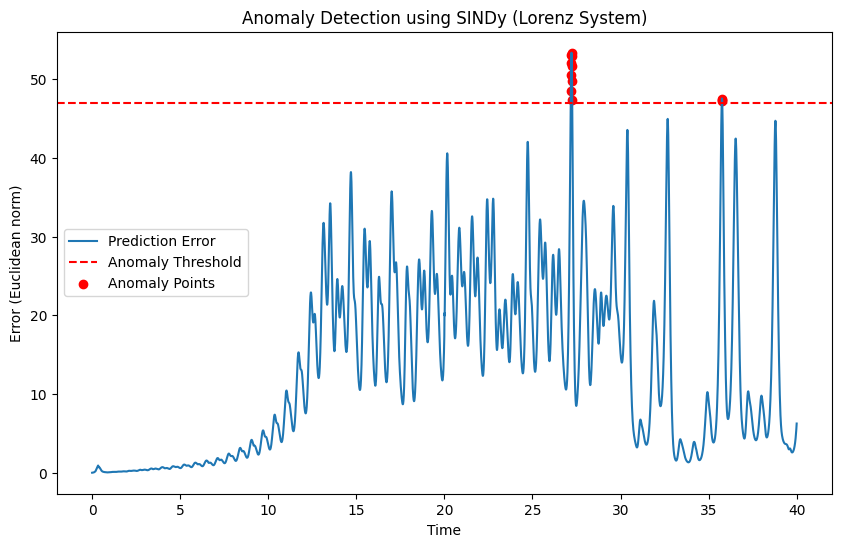

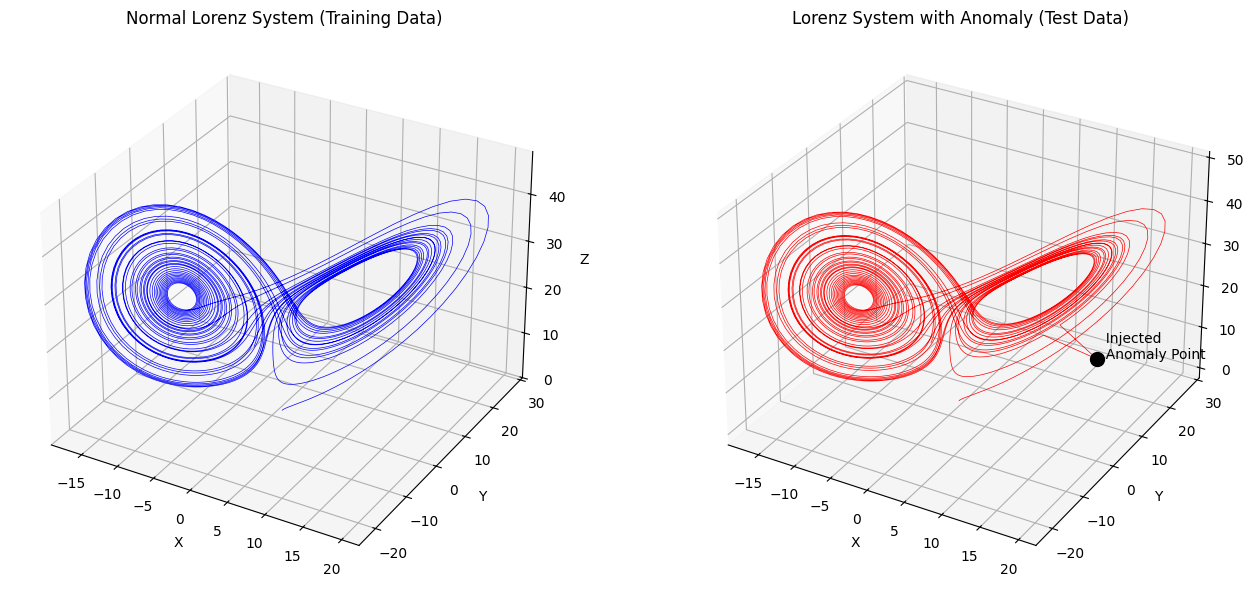

In [15]:
# (a) Plot the prediction error over time with anomaly threshold.
plt.figure(figsize=(10, 6))
plt.plot(t_test, error, label='Prediction Error')
plt.axhline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.scatter(t_test[anomaly_indices], error[anomaly_indices], color='red', label='Anomaly Points')
plt.xlabel('Time')
plt.ylabel('Error (Euclidean norm)')
plt.title('Anomaly Detection using SINDy (Lorenz System)')
plt.legend()
plt.show()

# (b) Plot 3D trajectories for the normal (training) and anomaly (test) cases.
fig = plt.figure(figsize=(14, 6))

# Normal Lorenz System (Training Data)
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(data_train[:, 0], data_train[:, 1], data_train[:, 2], color='blue', lw=0.5)
ax1.set_title('Normal Lorenz System (Training Data)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Lorenz System with Anomaly (Test Data)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(data_test[:, 0], data_test[:, 1], data_test[:, 2], color='red', lw=0.5)
ax2.set_title('Lorenz System with Anomaly (Test Data)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Add a pointer (marker and annotation) at the anomaly location
anomaly_point = data_test[anomaly_index]
ax2.scatter(anomaly_point[0], anomaly_point[1], anomaly_point[2],
            color='black', s=100, marker='o', label='Injected Anomaly Point')
ax2.text(anomaly_point[0], anomaly_point[1], anomaly_point[2],
         '  Injected   \n  Anomaly Point', color='black', fontsize=10)

plt.tight_layout()
plt.show()